# Lab 7: Implement a Neural Network for Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import time


Implement a neural network that performs sentiment analysis for a binary classification problem. 

1. Load the book review data set.
2. Create training and test datasets.
3. Transform the training and test text data using a TF-IDF vectorizer. 
4. Construct a neural network
5. Train the neural network.
6. Compare the model's performance on the training data vs test data.
7. Improve its generalization performance.

## Part 1:  Load the Data Set

We will work with the book review data set that contains book reviews taken from Amazon.com reviews.

You will be working with the file named "bookReviews.csv" that is located in a folder named "data".

In [2]:
df = pd.read_csv("data/bookReviews.csv", header=0)

In [3]:
df.head()

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


In [4]:
df.shape

(1973, 2)

## Part 2: Create Training and Test Data Sets

### Create Labeled Examples

* Get the `Positive_Review` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Get the `Review` column from  DataFrame `df` and assign it to the variable `X`. This will be our feature. 


In [5]:
y = df['Positive Review']
X = df['Review']

In [6]:
X.head()

0    This was perhaps the best of Johannes Steinhof...
1    This very fascinating book is a story written ...
2    The four tales in this collection are beautifu...
3    The book contained more profanity than I expec...
4    We have now entered a second time of deep conc...
Name: Review, dtype: object

In [7]:
X.shape

(1973,)

### Split Labeled Examples into Training and Test Sets   

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [9]:
X_train.head()

1369    As my brother said when flipping through this ...
1366    Cooper's book is yet another warm and fuzzy ma...
385     I have many robot books and this is the best a...
750     As China re-emerges as a dominant power in the...
643     I have been a huge fan of Michael Crichton for...
Name: Review, dtype: object

## Part 3:  Implement TF-IDF Vectorizer to Transform Text


In the code cell below, transform the features into numerical vectors. 

1. Create a `TfidfVectorizer`.

2. Call `tfidf_vectorizer.fit()` to fit the vectorizer to the training data.

3. Call the `tfidf_vectorizer.transform()` method to use the fitted vectorizer to transform the training data.

4. Call the `tfidf_vectorizer.transform()` method to use the fitted vectorizer to transform the test data. 

In [10]:
# 1. Create a TfidfVectorizer object 
tfidf_vectorizer = TfidfVectorizer()


# 2. Fit the vectorizer to X_train
tfidf_vectorizer.fit(X_train)


# 3. Using the fitted vectorizer, transform the training data 
X_train_tfidf = tfidf_vectorizer.transform(X_train)

# 4. Using the fitted vectorizer, transform the test data 
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [11]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)

print(vocabulary_size)

19029


## Part 4: Construct a Neural Network


### Step 1.  Define Model Structure

* <b>Input layer</b>: The input layer will have the input shape corresponding to the vocabulary size. 
* <b>Hidden layers</b>: We will create three hidden layers of widths (number of nodes) 64, 32, and 16. They will utilize the ReLu activation function. 
* <b>Output layer</b>: The output layer will have a width of 1. The output layer will utilize the sigmoid activation function. Since we are working with binary classification, we will be using the sigmoid activation function to map the output to a probability between 0.0 and 1.0. We can later set a threshold and assume that the prediction is class 1 if the probability is larger than or equal to our threshold, or class 0 if it is lower than our threshold.

To construct the neural network model:
* We will use the Keras `Sequential` class to group a stack of layers. 
* We will use the `Dense` class to create each layer. 
* We will add each layer to the neural network model object.   

In [12]:
nn_model = keras.Sequential()
input_layer = keras.layers.InputLayer(input_shape=(vocabulary_size,))
nn_model.add(input_layer)
hidden_layer_1 = keras.layers.Dense(units = 64, activation='relu')
nn_model.add(hidden_layer_1)
hidden_layer_2 = keras.layers.Dense(units = 32, activation='relu')
nn_model.add(hidden_layer_2)
hidden_layer_3 = keras.layers.Dense(units = 16, activation='relu')
nn_model.add(hidden_layer_3)
nn_model.add(keras.layers.Dropout(.25))
output_layer = keras.layers.Dense(units = 1, activation='sigmoid')
nn_model.add(output_layer)
nn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1217920   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,220,545
Trainable params: 1,220,545
Non-trainable params: 0
_________________________________________________________________


### Step 2. Define the Optimization Function

In [13]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)

### Step 3. Define the Loss Function

In [14]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits = False)

### Step 4. Compile the Model

Package the network architecture with the optimizer and the loss function using the `compile()` method.   

In [15]:
nn_model.compile(optimizer = sgd_optimizer, loss=loss_fn, metrics = ['accuracy'])

## Part 5. Fit the Model on the Training Data

In [16]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))


Fit the neural network model to the vectorized training data.
<b>Note</b>: This may take a while to run.

In [20]:


num_epochs = 50

t0 = time.time() # start time
history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs = num_epochs, verbose= 0, callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=num_epochs)], validation_split = 0.2)
t1 = time.time() # stop time
print('Number of epochs: ', (num_epochs))




Epoch [50/ 50], Loss: 0.0004, Accuracy: 1.0000, Val_loss: 1.1183, Val_accuracy: 0.8101
Number of epochs:  50


### Visualize the Model's Performance Over Time

The code above outputs both the training loss and accuracy and the validation loss and accuracy. Visualize the model's performance over time:

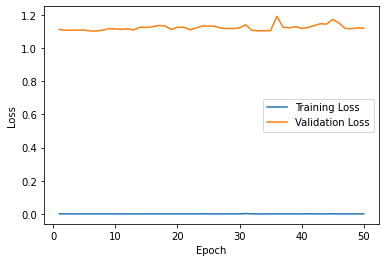

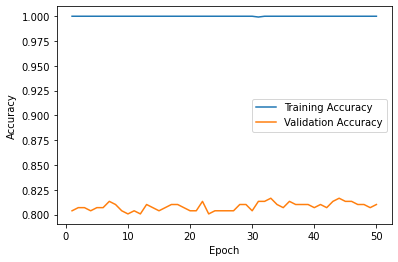

In [21]:
# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Part 6. Improve the Model and Evaluate the Performance

Evaluate its performance on our test data and compare the results.

In [22]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)


print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

13/13 [==============================] - 0s 6ms/step - loss: 1.1557 - accuracy: 0.8177
Loss:  1.1557179689407349 Accuracy:  0.8177215456962585


### Prevent Overfitting and Improve Model's Performance

Neural networks can be prone to overfitting. Notice that the training accuracy is 100% but the test accuracy is around 82%. This indicates that our model is overfitting; it will not perform as well to new, previously unseen data as it did during training. We want to have an accurate idea of how well our model will generalize. Our goal is to have our training and testing accuracy scores be as close as possible.

While there are different techniques that can be used to prevent overfitting, for the purpose of this exercise, we will focus on two methods:

1. Changing the number of epochs. Too many epochs can lead to overfitting of the training dataset, whereas too few epochs may result in underfitting.

2. Adding dropout regularization. During training, the nodes of a particular layer may always become influenced only by the output of a particular node in the previous layer, causing overfitting. Dropout regularization is a technique that randomly drops a number of nodes in a neural network during training as a way to adding randomization and prevent nodes from becoming dependent on one another. Adding dropout regularization can reduce overfitting and also improve the performance of the model. 

<b>Task:</b> 

1. Tweak the variable `num_epochs` above and restart and rerun all of the cells above. Evaluate the performance of the model on the training data and the test data.

2. Add Keras `Dropout` layers after one or all hidden layers. Add the following line of code after you add a hidden layer to your model object:  `nn_model.add(keras.layers.Dropout(.25))`. The parameter `.25` is the fraction of the nodes to drop. You can experiment with this value as well. Restart and rerun all of the cells above. Evaluate the performance of the model on the training data and the test data.


<b>Analysis:</b> 
In the cell below, specify the different approaches you used to reduce overfitting and summarize which configuration led to the best generalization performance.

Did changing the number of epochs prevent overfitting? Which value of `num_epochs` yielded the closest training and testing accuracy score? Recall that too few epochs can lead to underfitting (both poor training and test performance). Which value of `num_epochs` resulted in the best accuracy score when evaluating the test data?

Did adding dropout layers prevent overfitting? How so? Did it also improve the accuracy score when evaluating the test data? How many dropout layers did you add and which fraction of nodes did you drop? 

Record your findings in the cell below.

At very low epoch numbers, the loss is incredibly high with much more loss than there is accuracy. Starting around 25 epochs, the accuracy becomes high and the loss almost 0. Increasing the number of epochs to greater than 100, leads to very long computational times which may not be worth the small gain in accuracy.
Effect of adding drop out layer : Adding a dropout layer resulted in slightly slower increase in accuracy, though the difference is mostly neglible.

A number between 25 and 50 seems to be an optimal number of epochs.

Without dropout layer 

Epoch [1/ [1, 10, 25, 50, 100, 150]], Loss: 0.6933, Accuracy: 0.5024, Val_loss: 0.6930, Val_accuracy: 0.4905 Number of epochs: 1

Epoch [10/ [1, 10, 25, 50, 100, 150]], Loss: 0.6070, Accuracy: 0.6537, Val_loss: 0.5790, Val_accuracy: 0.6741 Number of epochs: 10

Epoch [25/ [1, 10, 25, 50, 100, 150]], Loss: 0.0036, Accuracy: 1.0000, Val_loss: 0.5009, Val_accuracy: 0.8196 Number of epochs: 25

Epoch [50/ [1, 10, 25, 50, 100, 150]], Loss: 0.0004, Accuracy: 1.0000, Val_loss: 0.6112, Val_accuracy: 0.8133 Number of epochs: 50

Epoch [100/ [1, 10, 25, 50, 100, 150]], Loss: 0.0001, Accuracy: 1.0000, Val_loss: 0.6775, Val_accuracy: 0.8196 Number of epochs: 100

Epoch [150/ [1, 10, 25, 50, 100, 150]], Loss: 0.0000, Accuracy: 1.0000, Val_loss: 0.7226, Val_accuracy: 0.8165 Number of epochs: 150

After adding dropout layer

Epoch [1/ [1, 10, 25, 50, 100, 150]], Loss: 0.6933, Accuracy: 0.5071, Val_loss: 0.6930, Val_accuracy: 0.5095
Number of epochs:  1

Epoch [10/ [1, 10, 25, 50, 100, 150]], Loss: 0.5807, Accuracy: 0.7425, Val_loss: 0.5873, Val_accuracy: 0.7753
Number of epochs:  10

Epoch [25/ [1, 10, 25, 50, 100, 150]], Loss: 0.0196, Accuracy: 1.0000, Val_loss: 0.5037, Val_accuracy: 0.8133
Number of epochs:  25

Epoch [50/ [1, 10, 25, 50, 100, 150]], Loss: 0.0026, Accuracy: 1.0000, Val_loss: 0.7512, Val_accuracy: 0.8038
Number of epochs:  50

Epoch [100/ [1, 10, 25, 50, 100, 150]], Loss: 0.0010, Accuracy: 1.0000, Val_loss: 0.9175, Val_accuracy: 0.8038
Number of epochs:  100

Epoch [150/ [1, 10, 25, 50, 100, 150]], Loss: 0.0002, Accuracy: 1.0000, Val_loss: 1.0891, Val_accuracy: 0.8038
Number of epochs:  150

### Make Predictions on the Test Set

Now that we have our best performing model that can generalize to new, previously unseen data, let us make predictions using our test data.

In the cell below, we will make a prediction on our test set using the `predict()` method, receive a probability between 0.0 and 1.0, and then apply a threshold to obtain the the predicted class for each example. We will use a threshold of 0.5.

For the first 10 examples, we will output their probabilities and the corresponding classes. Examine the output to see how this works.

In [23]:
probability_predictions = nn_model.predict(X_test_tfidf.toarray())

print("Predictions for the first 10 examples:")
print("Probability\t\t\tClass")
for i in range(0,10):
    if probability_predictions[i] >= .5:
        class_pred = "Good Review"
    else:
        class_pred = "Bad Review"
    print(str(probability_predictions[i]) + "\t\t\t" + str(class_pred))

Predictions for the first 10 examples:
Probability			Class
[0.99999964]			Good Review
[0.99704254]			Good Review
[0.3169878]			Bad Review
[0.06838852]			Bad Review
[0.99581516]			Good Review
[0.99662757]			Good Review
[1.2022048e-06]			Bad Review
[3.4393224e-09]			Bad Review
[1.]			Good Review
[1.]			Good Review


In [24]:
print('Review #1:\n')
print(X_test.to_numpy()[56])

goodReview = True if probability_predictions[56] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[56]))

Review #1:

This commentary has many tremendous insights into the book of Romans.  Romans is one of the richest resources of truth within the Bible and John Stoot does a good job of unpacking it.  The book is written from a framework of the reader having a strong prior understanding of the Scriptures.  It is probably not considered a highly scholarly work, but it is not for the average reader to pick up for light reading either


Prediction: Is this a good review? True

Actual: Is this a good review? True



In [25]:
print('Review #2:\n')
print(X_test.to_numpy()[24])

goodReview = True if probability_predictions[24] >= .5 else False

print('\nPrediction: Is this a good review? {}\n'.format(goodReview)) 

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[24]))

Review #2:

I have read Baldacci's first four novels and have immensely enjoyed all of them.  This one, however, is just awful.  Not only the character's dialogue but even the story itself is written like a really bad detective movie.  The only thing I can think of to compare it to is this :  There was a series of Calvin and Hobbes cartoons where Calvin imagines himself as a private detective and they are written like the old detective shows, with lame lines like "The gun was loaded, and so was I".  That is exactly what this book is like, except it goes on for 400 pages.  There isn't a single interesting character in this book, in my opinion.  You just have to slog your way through the book to get to the end.  It's the Bataan Death March of novels.  I hope this is an aberration - I'll certainly give him another try since the first four novels that I read were so good.  But one more stinker like this one and I'll drop his name from my reading list


Prediction: Is this a good review? Fa